### Preliminaries


Additional Indicators

In [18]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
np.random.seed(69)
import seaborn as sns
sys.path.append(os.path.dirname(os.getcwd()))
from data_prep import fetch_data, time_series_features, add_lag_features, simple_moving_average
# from mean_reversion import mean_reversion_strategy
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import pandas_ta as ta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K

### Fetch Data

In [19]:
df = fetch_data('XOM', '2005-09-10', '2010-09-10')
# df['SMA_10'] = simple_moving_average(df, 10)
df = df.reset_index()
df['Date'] = df['Date'].dt.date
# df['Close_diff'] = df['Close'].diff(1)
df['RSI_15'] = (ta.rsi(df['Close'], length=15)).shift(1)
df.drop(columns=['Open', 'Volume', 'High','Low', 'Dividends', 'Stock Splits'], inplace=True)
df


,Date,Close,RSI_15
0,2005-09-12,32.938900,NaN
1,2005-09-13,32.596447,NaN
2,2005-09-14,32.912537,NaN
3,2005-09-15,32.907269,NaN
4,2005-09-16,33.560581,NaN
...,...,...,...
1253,2010-09-02,35.683132,55.975876
1254,2010-09-03,35.835075,56.684825
1255,2010-09-07,35.385082,57.942595
1256,2010-09-08,35.501957,53.054175


### Data Preparation

In [20]:
df = add_lag_features(df)
# df = time_series_features(df)
cols = list(df.columns)
cols.remove('Close')
cols.append('Close')
df = df[cols]
df = df.dropna()

In [21]:
df

,Date,RSI_15,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_5,Close_lag_10,Close
16,2005-10-04,40.750333,32.923092,33.476288,34.140114,34.045277,33.997860,31.900995
17,2005-10-05,29.655260,31.900995,32.923092,33.476288,34.087421,34.229675,31.058010
18,2005-10-06,23.904024,31.058010,31.900995,32.923092,34.140114,34.234959,30.857815
19,2005-10-07,22.779914,30.857815,31.058010,31.900995,33.476288,33.629066,31.400473
20,2005-10-10,32.058998,31.400473,30.857815,31.058010,32.923092,34.034752,30.820936
...,...,...,...,...,...,...,...,...
1253,2010-09-02,55.975876,35.595470,34.543568,34.479267,34.175396,34.648766,35.683132
1254,2010-09-03,56.684825,35.683132,35.595470,34.543568,34.946793,34.414997,35.835075
1255,2010-09-07,57.942595,35.835075,35.683132,35.595470,34.479267,34.771477,35.385082
1256,2010-09-08,53.054175,35.385082,35.835075,35.683132,34.543568,34.444218,35.501957


In [22]:
def windowed_df_to_date(df):
    dates = df['Date'].values
    features = df.drop(['Date', 'Close'], axis=1).values
    X = features.reshape((len(dates), features.shape[1], 1))
    y = df['Close'].values
    return X.astype(np.float32), y.astype(np.float32), dates

X, y, dates = windowed_df_to_date(df)


In [23]:
X = deepcopy(np.flip(X, axis = 1))

### Train/Val/Test Split


In [24]:
q_80 = int(len(df) * 0.8)
q_90 = int(len(df) * 0.9)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

dates_train = dates[:q_80]
dates_val = dates[q_80:q_90]
dates_test = dates[q_90:]

X_train = X_scaled[:q_80]
X_val = X_scaled[q_80:q_90]
X_test = X_scaled[q_90:]

y_train = y_scaled[:q_80]
y_val = y_scaled[q_80:q_90]
y_test = y_scaled[q_90:]

# df.loc[df.index < '2023-06-30']

In [25]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train sample:", X_train[0])
print("y_train sample:", y_train[0])

X_train shape: (993, 6, 1)
y_train shape: (993,)
X_train sample: [[-1.051193  ]
 [-1.0450693 ]
 [-1.0328215 ]
 [-1.1185515 ]
 [-1.1899941 ]
 [-0.17914428]]
y_train sample: -1.4856799


## Model

In [26]:
start_lr = 1e-8
end_lr = 1
# def lr_schedule(epoch, lr):
#     return lr * (end_lr/start_lr) ** (1/100)

# losses = []
# lrs = []
# lr_callback = LambdaCallback(on_batch_end=lambda batch, logs: lrs.append(K.get_value(model.optimizer.learning_rate)))
# loss_callback = LambdaCallback(on_batch_end=lambda batch, logs: losses.append(logs['loss']))


In [27]:
# learning_rates = [0.01, 0.03, 0.05, 0.08, 0.1, 0.001]
# histories = []
# models = []

# for lr in learning_rates:
#     model = Sequential([
#         layers.Input((X_train.shape[1], 1)),
#         layers.LSTM(64, return_sequences=True),
#         layers.LSTM(32),
#         layers.Dense(16, activation='relu'),
#         layers.Dense(1)
#     ])

#     model.compile(loss='mse', 
#                   optimizer=Adam(learning_rate=lr), 
#                   metrics=['mean_absolute_error'])

#     history = model.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val), verbose=1)
    
#     histories.append(history)
#     models.append(model)

# Find the best model based on validation loss


### 

### Visualization

#### Loss Visualization

In [28]:
# plt.figure(figsize=(12, 8))
# for i, history in enumerate(histories):
#     plt.plot(history.history['loss'], label=f'Training Loss (LR: {learning_rates[i]})')
#     plt.plot(history.history['val_loss'], label=f'Validation Loss (LR: {learning_rates[i]})')

# plt.title('Model Loss for Different Learning Rates')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

#### MAE Visualization

In [29]:
# plt.figure(figsize=(12, 8))
# for i, history in enumerate(histories):
#     plt.plot(history.history['mean_absolute_error'], label=f'Training MAE (LR: {learning_rates[i]})')
#     plt.plot(history.history['val_mean_absolute_error'], label=f'Validation MAE (LR: {learning_rates[i]})')
# plt.title('Model Mean Absolute Error for Different Learning Rates')
# plt.ylabel('MAE')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

### Predictions


In [30]:
# best_model_index = np.argmin([h.history['val_loss'][-1] for h in histories])
# best_model = models[best_model_index]
# best_lr = learning_rates[best_model_index]

# print(f"Best learning rate: {best_lr}")

In [31]:
model = Sequential([
    layers.Input((X_train.shape[1], 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', 
                optimizer=Adam(learning_rate=0.001), 
                metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val), verbose=1)

Epoch 1/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8673 - mean_absolute_error: 0.7496 - val_loss: 0.0835 - val_mean_absolute_error: 0.2636
Epoch 2/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0754 - mean_absolute_error: 0.2195 - val_loss: 0.0472 - val_mean_absolute_error: 0.1926
Epoch 3/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0405 - mean_absolute_error: 0.1495 - val_loss: 0.0320 - val_mean_absolute_error: 0.1544
Epoch 4/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0355 - mean_absolute_error: 0.1385 - val_loss: 0.0254 - val_mean_absolute_error: 0.1353


In [32]:
train_pred = model.predict(X_train).flatten()
train_pred = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


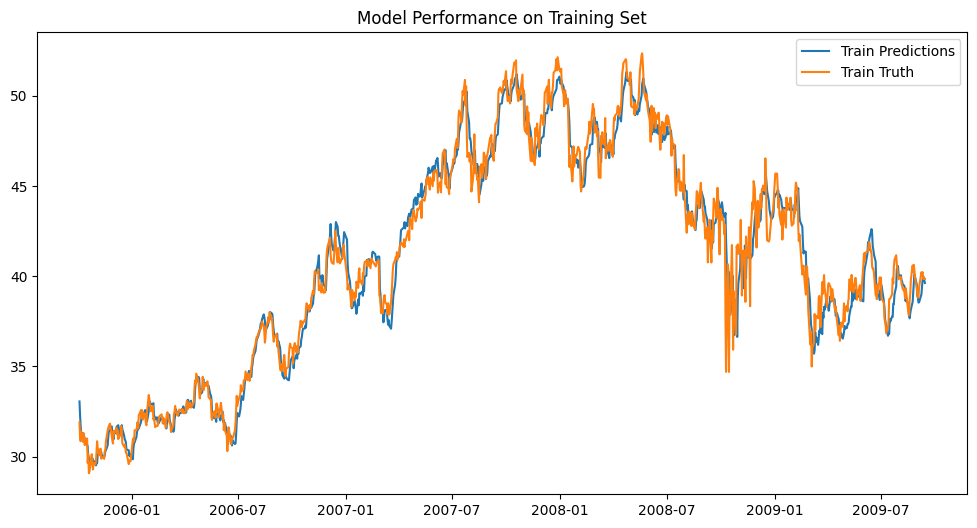

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_pred, label='Train Predictions')
plt.plot(dates_train, y_train_original, label='Train Truth')
plt.title('Model Performance on Training Set')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Set MAE: 0.5499
Test Set MSE: 0.4883
Test Set RMSE: 0.6988


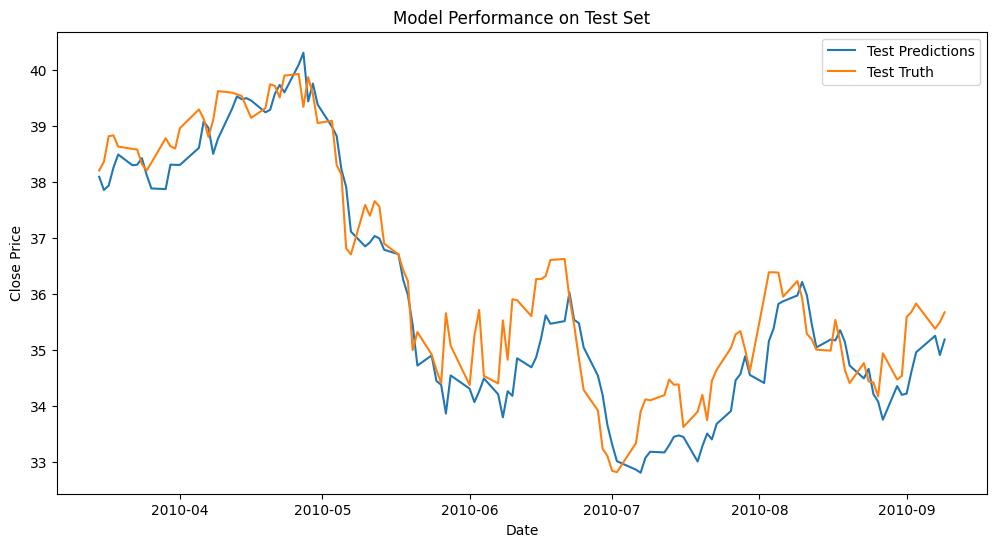

In [34]:
test_pred = model.predict(X_test).flatten()
test_pred = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_original, test_pred)
mse = mean_squared_error(y_test_original, test_pred)
rmse = np.sqrt(mse)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_pred, label='Test Predictions')
plt.plot(dates_test, y_test_original, label='Test Truth')
plt.title('Model Performance on Test Set')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [35]:
residuals = abs(test_pred - y_test_original)

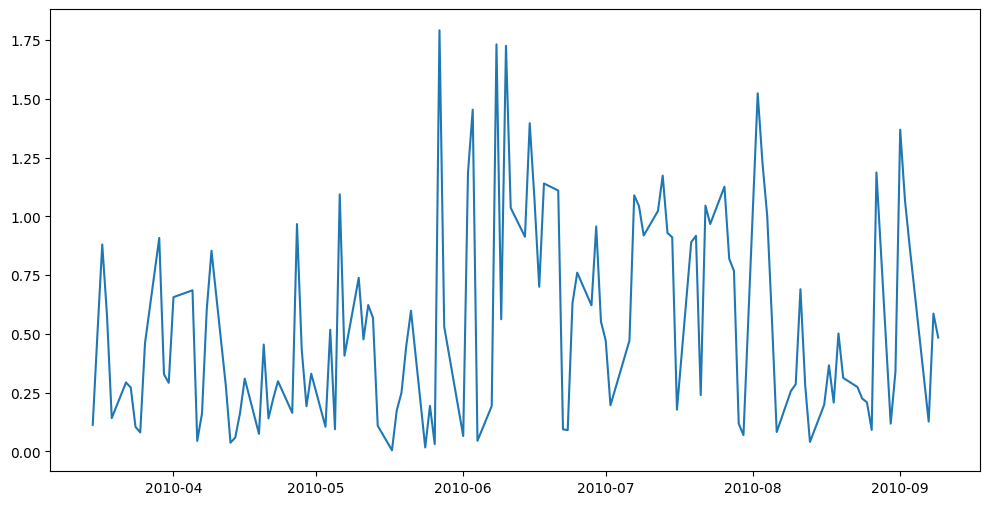

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, residuals, label='Test Predictions')

#### Current Considerations

Currently, the model is accurate only on next day predictions. Thus, we need to check the accuracy of multi-day forecasting

In [37]:
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_test_unscaled = scaler_X.inverse_transform(X_test_2d)
pd.DataFrame(X_test_unscaled)


,0,1,2,3,4,5
0,37.691875,38.314335,38.740799,38.740799,38.498753,55.330315
1,37.743755,38.487213,38.740799,38.498753,38.210579,50.801300
2,37.709179,38.740799,38.498753,38.210579,38.366188,53.025856
3,37.691875,38.740799,38.210579,38.366188,38.821491,58.857719
4,38.308556,38.498753,38.366188,38.821491,38.838791,59.064610
...,...,...,...,...,...,...
120,34.648766,34.175396,34.479267,34.543568,35.595470,55.975876
121,34.414997,34.946793,34.543568,35.595470,35.683132,56.684826
122,34.771477,34.479267,35.595470,35.683132,35.835075,57.942596
123,34.444218,34.543568,35.683132,35.835075,35.385082,53.054176


In [38]:
dates_test

array([datetime.date(2010, 3, 15), datetime.date(2010, 3, 16),
       datetime.date(2010, 3, 17), datetime.date(2010, 3, 18),
       datetime.date(2010, 3, 19), datetime.date(2010, 3, 22),
       datetime.date(2010, 3, 23), datetime.date(2010, 3, 24),
       datetime.date(2010, 3, 25), datetime.date(2010, 3, 26),
       datetime.date(2010, 3, 29), datetime.date(2010, 3, 30),
       datetime.date(2010, 3, 31), datetime.date(2010, 4, 1),
       datetime.date(2010, 4, 5), datetime.date(2010, 4, 6),
       datetime.date(2010, 4, 7), datetime.date(2010, 4, 8),
       datetime.date(2010, 4, 9), datetime.date(2010, 4, 12),
       datetime.date(2010, 4, 13), datetime.date(2010, 4, 14),
       datetime.date(2010, 4, 15), datetime.date(2010, 4, 16),
       datetime.date(2010, 4, 19), datetime.date(2010, 4, 20),
       datetime.date(2010, 4, 21), datetime.date(2010, 4, 22),
       datetime.date(2010, 4, 23), datetime.date(2010, 4, 26),
       datetime.date(2010, 4, 27), datetime.date(2010, 4, 28)

In [39]:
dates_test_minus_15 = dates_test[0] - pd.Timedelta(days=15)


In [40]:
og = df[df['Date'] >= dates_test_minus_15]
og = og.reset_index(drop = True)


In [41]:
og

,Date,RSI_15,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_5,Close_lag_10,Close
0,2010-03-01,43.003376,37.461357,37.542038,37.778355,37.691875,37.346100,37.691875
1,2010-03-02,46.000549,37.691875,37.461357,37.542038,37.426788,38.199059,37.743755
2,2010-03-03,46.676689,37.743755,37.691875,37.461357,37.778355,37.899353,37.709179
3,2010-03-04,46.263046,37.709179,37.743755,37.691875,37.542038,38.014641,37.691875
4,2010-03-05,46.044261,37.691875,37.709179,37.743755,37.461357,37.962757,38.308556
...,...,...,...,...,...,...,...,...
130,2010-09-02,55.975876,35.595470,34.543568,34.479267,34.175396,34.648766,35.683132
131,2010-09-03,56.684825,35.683132,35.595470,34.543568,34.946793,34.414997,35.835075
132,2010-09-07,57.942595,35.835075,35.683132,35.595470,34.479267,34.771477,35.385082
133,2010-09-08,53.054175,35.385082,35.835075,35.683132,34.543568,34.444218,35.501957


### Multi-Day Forecasting

In [42]:
def generate_sequences(model, num_days, scaler_X, scaler_y, og):
    predictions = []
    temp = og.copy()

    for i in range(num_days):
      
        rsi = ta.rsi(temp['Close'][i:i+16], length = 15)
        temp.loc[temp.Date == dates_test[i], 'RSI_15'] = rsi.values[-1]

        previous_days = temp[temp.Date < dates_test[i]].sort_values('Date', ascending=False)


        # Update the lagged Close prices
        lag1 = previous_days.iloc[0]['Close']
        lag2 = previous_days.iloc[1]['Close']
        lag3 = previous_days.iloc[2]['Close']
        lag5 = previous_days.iloc[4]['Close']
        lag10 = previous_days.iloc[9]['Close']
        print(lag1)


        temp.loc[temp.Date == dates_test[i], 'Close_lag_1'] = lag1
        temp.loc[temp.Date == dates_test[i], 'Close_lag_2'] = lag2
        temp.loc[temp.Date == dates_test[i], 'Close_lag_3'] = lag3
        temp.loc[temp.Date == dates_test[i], 'Close_lag_5'] = lag5
        temp.loc[temp.Date == dates_test[i], 'Close_lag_10'] = lag10
        
        # Create the new input sequence for the next prediction
        new_input = np.array([
            lag10,
            lag5,
            lag3,
            lag2,
            lag1,
            rsi.values[-1]
        ])
        # Scale the new input
        new_input = new_input.reshape((1, -1))

        scaler = StandardScaler()
        new_input_scaled = scaler.fit_transform(new_input.reshapre())

        # Scale the new input
        new_input_scaled = scaler_X.transform(new_input).reshape((1, new_input.shape[1], 1))
        new_input_scaled =deepcopy(np.flip(new_input_scaled, axis = 1))
        pred = model.predict(new_input_scaled)[0][0]
        pred_unscaled = scaler_y.inverse_transform([[pred]])[0][0]
        temp.loc[temp.Date == dates_test[i], 'Close'] = pred_unscaled

        # Append the prediction
        predictions.append(pred)

    return np.array(predictions), temp



In [43]:
num_days_to_predict = 30
initial_sequence = X_test[0]
multi_day_predictions, temp = generate_sequences(model, num_days_to_predict, scaler_X, scaler_y, og)


38.49875259399414


ValueError: X has 6 features, but StandardScaler is expecting 1 features as input.

In [ ]:
og

In [ ]:
temp

In [ ]:
multi_day_predictions = scaler_y.inverse_transform(multi_day_predictions.reshape(-1, 1)).flatten()

#### Prediction Visualization

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test[:num_days_to_predict], y_test_original[:num_days_to_predict], label='Actual')
plt.plot(dates_test[:num_days_to_predict], multi_day_predictions, label='Multi-day Forecast')
plt.title('Multi-day Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### MAE for Multi-Day

In [ ]:
mae_multi = mean_absolute_error(y_test_original[:num_days_to_predict], multi_day_predictions)
mse_multi = mean_squared_error(y_test_original[:num_days_to_predict], multi_day_predictions)
rmse_multi = np.sqrt(mse_multi)

In [ ]:
print(f"Multi-day Forecast MAE: {mae_multi:.4f}")
print(f"Multi-day Forecast MSE: {mse_multi:.4f}")
print(f"Multi-day Forecast RMSE: {rmse_multi:.4f}")